In [63]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from HD_BET.run import run_hd_bet
from HD_BET.utils import subdirs, subfiles
import sys
import os
from dipy.viz import regtools
from dipy.align.imaffine import (AffineMap,
                                MutualInformationMetric,
                                  AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)
import nibabel as nib


In [19]:
trans = sitk.TranslationTransform(3) # GetParameters (px, py, pz)
trans.SetParameters((2, 2, 3))

t = sitk.Euler3DTransform() # GetParameters (Angx, Angy, Angz, px, py, pz)
t.SetTranslation(trans.GetParameters())
t.SetRotation(angleX=0.1, angleY=-0.3, angleZ=0.5)

aff = sitk.AffineTransform(3) # GetParameters (matrix elements row-order ... px, py, pz)
aff.SetTranslation(t.GetTranslation())
aff.SetMatrix(t.GetMatrix())

print(trans)
print(t)
print(aff)

itk::simple::TranslationTransform
 TranslationTransform (000001F74C579380)
   RTTI typeinfo:   class itk::TranslationTransform<double,3>
   Reference Count: 1
   Modified Time: 1764
   Debug: Off
   Object Name: 
   Observers: 
     none
   Offset: [2, 2, 3]

itk::simple::Euler3DTransform
 Euler3DTransform (000001F74F1B7C20)
   RTTI typeinfo:   class itk::Euler3DTransform<double>
   Reference Count: 1
   Modified Time: 1765
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.852531 -0.47703 -0.213618 
     0.432122 0.873198 -0.225379 
     0.294044 0.0998334 0.950564 
   Offset: [2, 2, 3]
   Center: [0, 0, 0]
   Translation: [2, 2, 3]
   Inverse: 
     0.852531 0.432122 0.294044 
     -0.47703 0.873198 0.0998334 
     -0.213618 -0.225379 0.950564 
   Singular: 0
   Euler's angles: AngleX=0.1 AngleY=-0.3 AngleZ=0.5
   m_ComputeZYX = 0

itk::simple::AffineTransform
 AffineTransform (000001F7527BE820)
   RTTI typeinfo:   class itk::AffineTransform<double,3>
   Refer

In [64]:
datadir = "C:/Users/noahj/OneDrive/Documents/miaproject2/BrainExtracted"

SKULL STRIPPING

In [14]:

input_files = []
for dir in subdirs(datadir):
    input_files.extend(subfiles(dir))
output_files = [ifile[:-7]+"_bet.nii.gz" for ifile in input_files]
run_hd_bet(input_files[0:12], output_files[0:12])

File: C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2\001\ADC_deformed.nii.gz
preprocessing...
image shape after preprocessing:  (121, 145, 121)
prediction (CNN id)...
0
1
2
3
4
exporting segmentation...
File: C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2\001\FA_deformed.nii.gz
preprocessing...
image shape after preprocessing:  (121, 145, 121)
prediction (CNN id)...
0
1
2
3
4
exporting segmentation...
File: C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2\001\T1w_1mm.nii.gz
preprocessing...
image shape after preprocessing:  (121, 145, 121)
prediction (CNN id)...
0
1
2
3
4
exporting segmentation...
File: C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2\001\T2w_1mm_noalign.nii.gz
preprocessing...
image shape after preprocessing:  (121, 145, 121)
prediction (CNN id)...
0
1
2
3
4
exporting segmentation...
File: C:/Users/noahj/OneDrive/Documents/miaproject2/MedIA_Project2\002\ADC_deformed.nii.gz
preprocessing...
image shape after preproces

RIGID REGISTRATION FUNCTION

REGISTRATION

In [27]:
moving_img = nib.load(os.path.join(datadir, "001", "T2w_1mm_noalign_bet.nii.gz"))
template_img = nib.load(os.path.join(datadir, "001", "T1w_1mm_bet.nii.gz"))
moving_data = moving_img.get_fdata()
moving_affine = moving_img.affine
template_data = template_img.get_fdata()
template_affine = template_img.affine
print(type(moving_data))

<class 'numpy.ndarray'>


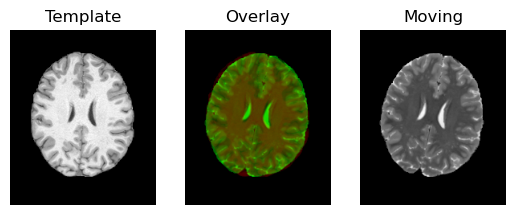

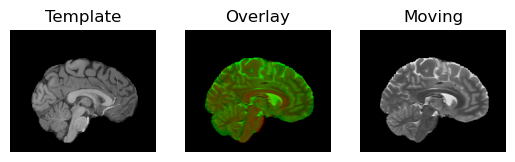

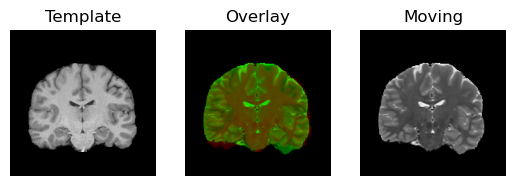

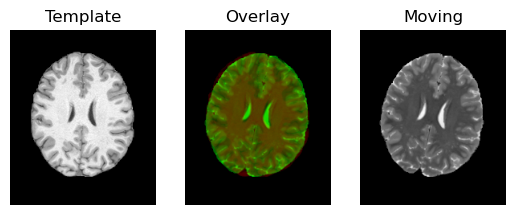

In [19]:
identity = np.eye(4)
affine_map = AffineMap(identity,
                       template_data.shape, template_affine,
                       moving_data.shape, moving_affine)
resampled = affine_map.transform(moving_data)
regtools.overlay_slices(template_data, moving_data, None, 0,
                        "Template", "Moving")

regtools.overlay_slices(template_data, moving_data, None, 1,
                        "Template", "Moving")

regtools.overlay_slices(template_data, moving_data, None, 2,
                        "Template", "Moving")

Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]


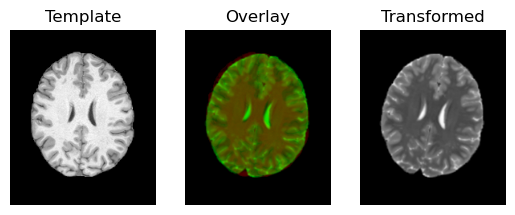

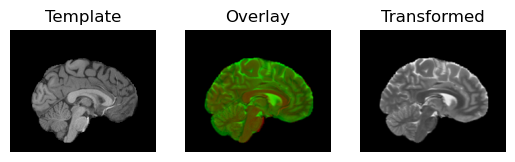

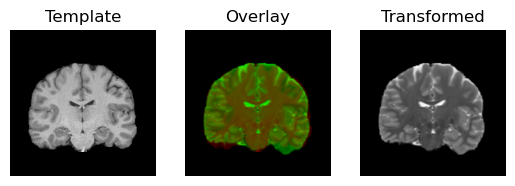

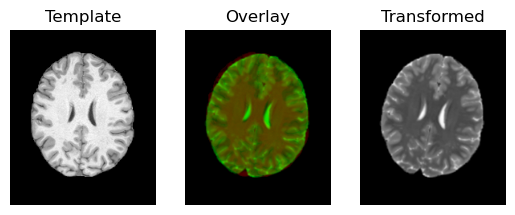

In [20]:
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)
level_iters = [10, 10, 5]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]
affreg = AffineRegistration(metric=metric, level_iters=level_iters, sigmas=sigmas, factors=factors)
transform = TranslationTransform3D()
translation = affreg.optimize(template_data, moving_data, transform, None, template_affine, moving_affine)
transformed = translation.transform(moving_data)
regtools.overlay_slices(template_data, transformed, None, 0,
                        "Template", "Transformed")

regtools.overlay_slices(template_data, transformed, None, 1,
                        "Template", "Transformed")

regtools.overlay_slices(template_data, transformed, None, 2,
                        "Template", "Transformed")

Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]


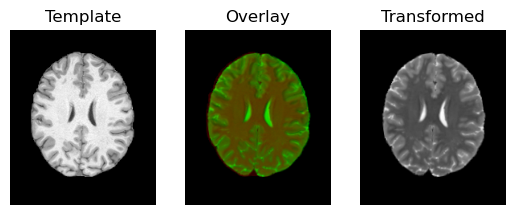

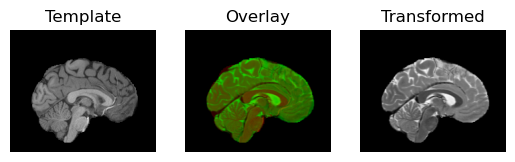

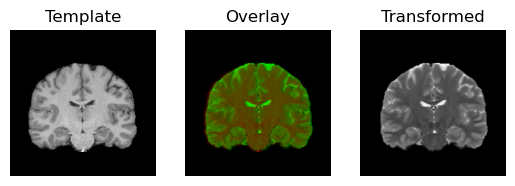

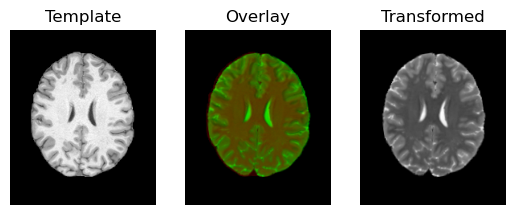

In [22]:
transform = RigidTransform3D()
rigid = affreg.optimize(template_data, moving_data, transform, None, template_affine, moving_affine)
transformed = rigid.transform(moving_data)
regtools.overlay_slices(template_data, transformed, None, 0,
                        "Template", "Transformed")

regtools.overlay_slices(template_data, transformed, None, 1,
                        "Template", "Transformed")

regtools.overlay_slices(template_data, transformed, None, 2,
                        "Template", "Transformed")

REGISTRATION LOOP

In [30]:
sz = FA.GetSize()
print(np.array(sz)/2)

[72.5 87.  72.5]


In [49]:
def registerSITK(fixed, moving, rigid=False, lr=1.0, printmetric=False):
    # ITERATIVE REGISTRATION
    # for i in range(0, 3):
    #     if (i == 0): # first, perform translation registration
    #         print('Peforming translation registration ...')
    #         offset = np.array(fixed.GetSize())/2 - np.array(moving.GetSize())/2
    #         initial_transform = sitk.TranslationTransform(3, offset)
    #     elif (i == 1): # next, add rotation
    #         initial_transform = sitk.Euler3DTransform()
    #         final_transform = final_transform.GetBackTransform() # extract Translation from 1 element transform queue
    #         initial_transform.SetTranslation(final_transform.GetParameters())
    #         initial_transform.SetCenter(np.array(moving.GetSize())/2) # set rotation center to moving img center
    #         print('Peforming full rigid registration ...')
    #     elif (not rigid): # finally, add scale and shear if ADC or FA
            # initial_transform = sitk.AffineTransform(3)
            # final_transform = final_transform.GetBackTransform() # extract Euler3D from 1 element transform queue
            # initial_transform.SetTranslation(final_transform.GetTranslation())
            # initial_transform.SetMatrix(final_transform.GetMatrix())
            # initial_transform.SetCenter(final_transform.GetCenter()) # keep rotation center
    if rigid:
        initial_transform = sitk.CenteredTransformInitializer(fixed, 
                                                        moving, 
                                                        sitk.Euler3DTransform(),
                                                        sitk.CenteredTransformInitializerFilter.GEOMETRY)
        print('Peforming full rigid registration ...')
    else:
        initial_transform = sitk.CenteredTransformInitializer(fixed, 
                                                        moving, 
                                                        sitk.AffineTransform(3),
                                                        sitk.CenteredTransformInitializerFilter.GEOMETRY)
        print('Peforming full non-rigid registration ...')
    # else: # if last iteration and using T2, then we are done
    #     break

    
    registration_method = sitk.ImageRegistrationMethod()
    # if (T2):
    #     registration_method.SetMetricAsANTSNeighborhoodCorrelation(radius=2)
    # else:
    registration_method.SetMetricAsJointHistogramMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.5, 1)

    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsGradientDescent(learningRate=lr, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    if (printmetric):
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: print('Metric value: {0}'.format(registration_method.GetMetricValue())))
    # Run optimization
    final_transform = registration_method.Execute(fixed, moving)
    # Always check the reason optimization terminated.
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    return final_transform

In [76]:
def registerimg(fixed, moving, rigid=True, nbins=32,
             sampling_prop=10, level_iters=[10, 10, 5], sigmas = [3.0, 1.0, 0.0],
             factors=[4, 2, 1]):
    # Obtain data array and affine representations
    fixed_data = fixed.get_fdata()
    fixed_affine = fixed.affine
    moving_data = moving.get_fdata()
    moving_affine = moving.affine

    metric = MutualInformationMetric(nbins, sampling_prop)

    # Perform Translation first
    affreg = AffineRegistration(metric=metric, level_iters=level_iters, sigmas=sigmas, factors=factors)
    # transform = TranslationTransform3D()
    # translation_reg = affreg.optimize(fixed_data, moving_data, transform, None, fixed_affine, moving_affine)
    # Then full rigid
    transform = RigidTransform3D()
    rigid_reg = affreg.optimize(fixed_data, moving_data, transform, None, fixed_affine, moving_affine)#, starting_affine=translation_reg.affine)
    
    # Then full affine, if not just rigid
    if not rigid:
        transform = AffineTransform3D()
        affreg.level_iters = [50, 20, 5] # increase iterations for a more exact fit
        affine_reg = affreg.optimize(fixed_data, moving_data, transform, None, fixed_affine, moving_affine, starting_affine=rigid_reg.affine)
        finaltransform = affine_reg
    else:
        
        finaltransform = rigid_reg
    
    return finaltransform

Analyzing images for patient 001
Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]
Optimizing level 2 [max iter: 50]
Optimizing level 1 [max iter: 20]
Optimizing level 0 [max iter: 5]
Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]


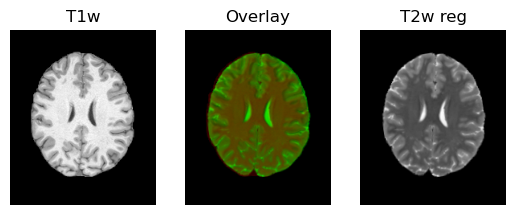

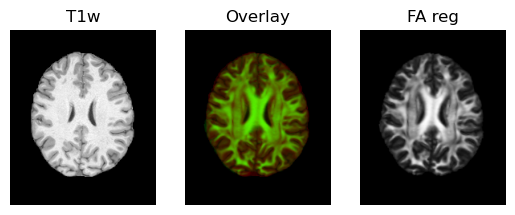

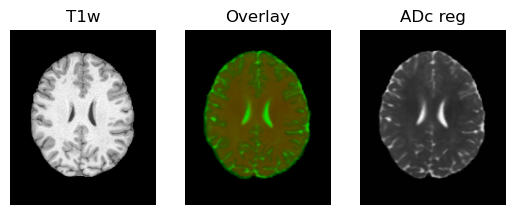

In [77]:
slices = [i/10 for i in range(3, 8)] # slices to plot for validation (given as percentage through the height)
showresults = ["001"] # choose the directories to plot the results for
register = True # true if we want to perform registration, otherwise we just want to plot existing registration
for dir in subdirs(datadir):
    # Run only in directories with skull-stripped images
    if dir[-3:] == "001" and os.path.exists(os.path.join(dir, "T1w_1mm_bet.nii.gz")):
        # Show current directory
        print(f"Analyzing images for patient {dir[-3:]}")

        # If we want to perform the registration
        if register:
            # # Read in images
            T1w = nib.load(os.path.join(dir, "T1w_1mm_bet.nii.gz"))
            T2w = nib.load(os.path.join(dir, "T2w_1mm_noalign_bet.nii.gz"))
            FA = nib.load(os.path.join(dir, "FA_deformed_bet.nii.gz"))
            ADC = nib.load(os.path.join(dir, "ADC_deformed_bet.nii.gz"))

            transformFA = registerimg(T1w, FA, rigid=False)
            # transformADC = registerimg(T1w, ADC, rigid=False)
            transformT2w = registerimg(T1w, T2w, rigid=True)
            T1wdata = T1w.get_fdata()
            FAreg = transformFA.transform(FA.get_fdata())
            ADCreg = transformFA.transform(ADC.get_fdata())
            T2wreg = transformT2w.transform(T2w.get_fdata())
            
            # print(FAreg.shape, ADCreg.shape, T2wreg.shape)
            # T1w = sitk.ReadImage(os.path.join(dir, "T1w_1mm_bet.nii.gz"))
            # T2w = sitk.ReadImage(os.path.join(dir, "T2w_1mm_noalign_bet.nii.gz"))
            # FA = sitk.ReadImage(os.path.join(dir, "FA_deformed_bet.nii.gz"))
            # ADC = sitk.ReadImage(os.path.join(dir, "ADC_deformed_bet.nii.gz"))

            # # Scale FA and ADC to T1w's size
            # # FAscaled = sitk.Resample(FA, T1w, sitk.ScaleTransform(3, (1, 1, 1)))
            # # ADCscaled = sitk.Resample(ADC, T1w, sitk.ScaleTransform(3, (1, 1, 1)))

            # # Run registration and obtain transformation objects
            # final_transformFA = registerSITK(T1w, FA, rigid=False, lr=1.0, printmetric=True)
            # final_transformT2w = registerSITK(T1w, T2w, rigid=True, lr=1.0, printmetric=True)
        
            # # Apply the transformation
            # ADCreg = sitk.Resample(ADC, T1w, final_transformFA) # since ADC and FA have same distortion
            # FAreg = sitk.Resample(FA, T1w, final_transformFA)
            # T2wreg = sitk.Resample(T2w, T1w, final_transformT2w)

            # # Scale and save resulting registered images
            # FAreg_ogsize = sitk.Resample(FAreg, FA, sitk.ScaleTransform(3, (1, 1, 1))) # scale FA back to 1.25mm res
            # ADCreg_ogsize = sitk.Resample(ADCreg, ADC, sitk.ScaleTransform(3, (1, 1, 1))) # scale ADC back to 1.25mm res
            # sitk.WriteImage(T2wreg, os.path.join(dir, "T2w_1mm_reg.nii.gz"))
            # sitk.WriteImage(FAreg_ogsize, os.path.join(dir, "FA_reg.nii.gz"))
            # sitk.WriteImage(ADCreg_ogsize, os.path.join(dir, "ADC_reg.nii.gz"))
        # If we just want to display existing registrations:
        else:
            # Ensure registered images exist, then read them in
            if not os.path.exists(os.path.join(dir, "T2w_1mm_reg.nii.gz")):
                print(f"Error: No registration found for patient {dir[-3:]}")
                break
            T1w = sitk.ReadImage(os.path.join(dir, "T1w_1mm_bet.nii.gz"))
            T2wreg = sitk.ReadImage(os.path.join(dir, "T2w_1mm_reg.nii.gz"))
            FAreg_ogsize = sitk.ReadImage(os.path.join(dir, "FA_reg.nii.gz"))
            ADCreg_ogsize = sitk.ReadImage(os.path.join(dir, "ADC_reg.nii.gz"))

        # Confirm sizes are correct
        # print(f"FA: {FAreg_ogsize.GetSize()}, ADC: {ADCreg_ogsize.GetSize()}, T2w: {T2wreg.GetSize()}, T1w: {T1w.GetSize()}")

        # Plot the registration results for selected folders
        if dir[-3:] in showresults:
            # Generate tiles of multiple top-down slices to plot
            # sizediff = FAreg_ogsize.GetSize()[2]
            # sizeT = T1w.GetSize()[2]
            # FAslices = [FAreg_ogsize[:, :, int(s*sizediff)] for s in slices]
            # ADCslices = [ADCreg_ogsize[:, :, int(s*sizediff)] for s in slices]
            # T2wslices = [T2wreg[:, :, int(s*sizeT)] for s in slices]
            # T1wslices = [T1w[:, :, int(s*sizeT)] for s in slices]
            
            # # Convert tiles to arrays for plotting
            # FAarr = sitk.GetArrayFromImage(sitk.Tile(FAslices, [len(slices), 1]))
            # ADCarr = sitk.GetArrayFromImage(sitk.Tile(ADCslices, [len(slices), 1]))
            # T2warr = sitk.GetArrayFromImage(sitk.Tile(T2wslices, [len(slices), 1]))
            # T1warr = sitk.GetArrayFromImage(sitk.Tile(T1wslices, [len(slices), 1]))
            # # print(FAarr.max(), ADCarr.max(), T2warr.max(), T1warr.max())

            # # Plot tiles
            # fig, axs = plt.subplots(4, 1, constrained_layout=True)
            # axs[0].imshow(T1warr, cmap='gray')
            # axs[0].set_title("T1w")
            # axs[1].imshow(T2warr, cmap='gray')
            # axs[1].set_title("T2w Reg.")
            # axs[2].imshow(FAarr, cmap='gray')
            # axs[2].set_title("FA Reg.")
            # axs[3].imshow(ADCarr, cmap='gray')
            # axs[3].set_title("ADC Reg.")
            # fig.suptitle(f"Registration for patient {dir[-3:]}")
            # fig.set_dpi(300)
            regtools.overlay_slices(T1wdata, T2wreg, None, 2,
                        "T1w", "T2w reg")

            regtools.overlay_slices(T1wdata, FAreg, None, 2,
                                    "T1w", "FA reg")

            regtools.overlay_slices(T1wdata, ADCreg, None, 2,
                                    "T1w", "ADc reg")

In [36]:
print(final_transformT2w)

itk::simple::CompositeTransform
 CompositeTransform (000001F73EA60840)
   RTTI typeinfo:   class itk::CompositeTransform<double,3>
   Reference Count: 1
   Modified Time: 1523811
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (000001F74F1BC030)
     RTTI typeinfo:   class itk::Euler3DTransform<double>
     Reference Count: 1
     Modified Time: 1523435
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.140927 -0.250749 -0.957739 
       0.986092 0.121646 0.11325 
       0.0881075 -0.960379 0.264405 
     Offset: [192.817, -3.86785, 164.169]
     Center: [91, 109, 91]
     Translation: [0.15591, 0.431661, 0.566715]
     Inverse: 
       0.140927 0.986092 0.0881075 
       -0.250749 0.121646 -0.960379 
       -0.957739 0.11325 0.264405 
     Singular: 0
     Euler's angles: AngleX=-82.9698 AngleY=137.908 AngleZ=-111.978
     m_ComputeZYX = 0
   End of MultiTransform.
<

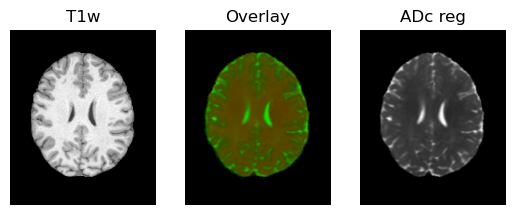

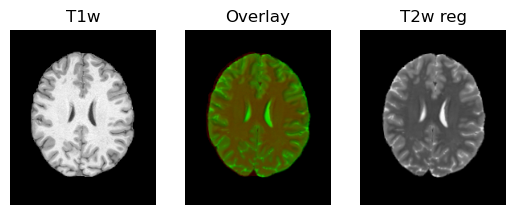

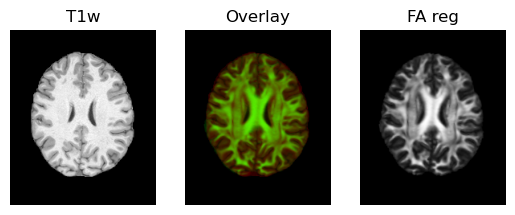

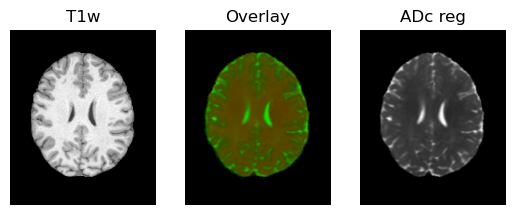

In [6]:
T1wdata = T1w.get_fdata()
FAdata = FA.get_fdata()
ADCdata = ADC.get_fdata()
T2wdata = T2w.get_fdata()
FAreg = transformFA.transform(FAdata)
ADCreg = transformADC.transform(ADCdata)
T2wreg = transformT2w.transform(T2wdata)
regtools.overlay_slices(T1wdata, T2wreg, None, 2,
                        "T1w", "T2w reg")

regtools.overlay_slices(T1wdata, FAreg, None, 2,
                        "T1w", "FA reg")

regtools.overlay_slices(T1wdata, ADCreg, None, 2,
                        "T1w", "ADc reg")

In [7]:
FAnew = nib.Nifti1Image(FAreg, FA.affine, FA.header)
nib.save(FAnew, os.path.join(datadir, "001", "FA_reg.nii.gz"))
ADCnew = nib.Nifti1Image(ADCreg, ADC.affine, ADC.header)
nib.save(ADCnew, os.path.join(datadir, "001", "ADC_reg.nii.gz"))
T2wnew = nib.Nifti1Image(T2wreg, T2w.affine, T2w.header)
nib.save(T2wnew, os.path.join(datadir, "001", "T2w_reg.nii.gz"))

In [31]:
print(FAreg.GetSize()[0])
sitk.Show(FAreg)

182


RuntimeError: Exception thrown in SimpleITK Show: D:\a\1\sitk\Code\IO\src\sitkImageViewer.cxx:620:
sitk::ERROR: No ImageJ/Fiji application found.